<a href="https://colab.research.google.com/github/spe301/AI-generated-AI/blob/main/AI_generated_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

Deep Learning is on the rise and it's starting to be established as the best Machine Learning strategy, especially for very large datasets and unstructured data (ie. Text and Images). The problem is that these models are often very computationally intensive and many people don't have the rescources to do an extensive gridsearch to find the best model. However, What if we could train a Machine Learning model to predict the best hyperparameter combination, rather than actually having to train several models we could just predict the loss of several hyperparameter combinations, extract the best combination, use those features to build and train just one model! This would save all kinds of time, effort, and compute time.

In [ ]:
!pip install Potosnail==0.2.4

In [ ]:
from potosnail import *

# Modeling

1. train a model on the results of training 2,000 RNN's of varying sizes, model parameters, training parameters, and datasets. We would ideally have far more than this but 2k is enough for an mvp. I also plan on expanding into computer vision problems in the future.

2. generate thousands of, 57,000 to be exact, possible combinations, and predict the quality score. quality score is the following formula...

Q = 1 - ($\frac{loss[i]}{max(loss)}$) + accuracy[i] / 2

3. Build a keras model in accordinance with the comboniation with the highest predicted Q value

In [ ]:
reg = Models().BuildML('RNN')
reg

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.1s finished


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Here I use the BuildML function and pass 'RNN' because we are training the model on the dataset of RNN training results

Obviousley not the best model here but this is a proof of concept. Let's try the twitter dataset...

Epoch 1/30
447/447 [==============================] - 20s 31ms/step - loss: 0.2284 - accuracy: 0.6718 - val_loss: 0.2227 - val_accuracy: 0.6667
Epoch 2/30
447/447 [==============================] - 12s 26ms/step - loss: 0.2122 - accuracy: 0.6789 - val_loss: 0.2287 - val_accuracy: 0.6486
Epoch 3/30
447/447 [==============================] - 12s 27ms/step - loss: 0.1693 - accuracy: 0.7540 - val_loss: 0.2705 - val_accuracy: 0.5936
Epoch 4/30
447/447 [==============================] - 12s 27ms/step - loss: 0.1328 - accuracy: 0.8093 - val_loss: 0.2907 - val_accuracy: 0.5897
Epoch 5/30
447/447 [==============================] - 12s 27ms/step - loss: 0.1144 - accuracy: 0.8407 - val_loss: 0.2693 - val_accuracy: 0.6115
Epoch 6/30
447/447 [==============================] - 12s 27ms/step - loss: 0.1064 - accuracy: 0.8521 - val_loss: 0.2927 - val_accuracy: 0.5889
Epoch 7/30
447/447 [==============================] - 12s 26ms/step - loss: 0.0978 - accuracy: 0.8593 - val_loss: 0.3370 - val_accuracy:

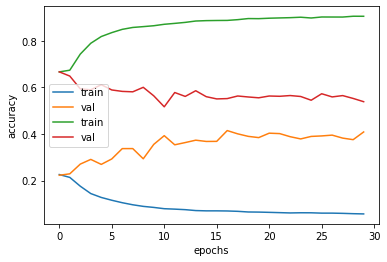

In [ ]:
wiki = Datasets().load_twitter()
X = wiki['data']
y = wiki['target']
v = wiki['vocab']

dm = Models().BuildRNN(reg, v, X, y.reshape(-1, 1), quiet=False)
dm.summary()

## other details
* batch size of 16
* L2 regularization
* adam optimizer

all of this was predicted by out Decision Tree Regressor!